This notebook creates a Recurrent neural network (RNN)

Import packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt
from collections import deque
import random

In [2]:
data = pds.read_pickle('../../added_t_ttjs.pkl')

In [3]:
data.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number,label,t,ttjs
0,1,1,2018-02-16 04:48:40+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1,72,71.0,0
1,3,3,2018-02-16 04:48:41+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1,72,70.0,0
2,4,4,2018-02-16 04:48:42+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1,72,69.0,0
3,5,5,2018-02-16 04:48:43+01:00,ObservedPositionEvent,5432,0,58.414257,15.571004,147.300003,0.0,NaN,1,1,72,68.0,0
4,6,6,2018-02-16 04:48:44+01:00,ObservedPositionEvent,5432,0,58.414257,15.571006,147.300003,0.0,NaN,1,1,72,67.0,0


One hot encode segments, normalize columns and create final dataset

In [4]:
df = data
dataset = pds.DataFrame()
# Make segments categorical
dataset = pds.get_dummies(df['segment_number'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 

dataset['hr_sin'] = np.sin((df.timestamp.dt.hour*60+df.timestamp.dt.minute)*(2.*np.pi/1440))
dataset['hr_cos'] = np.cos((df.timestamp.dt.hour*60+df.timestamp.dt.minute)*(2.*np.pi/1440))

# Convert to radians befor trigonometric functions
dataset['dir_sin'] = np.sin(df.direction*(np.pi/180))
dataset['dir_cos'] = np.cos(df.direction*(np.pi/180))

dataset['speed'] = (df['speed']-df['speed'].min())/(df['speed'].max()-df['speed'].min())
# Previousla was 'time_since_journey_start'
dataset['ttjs'] = (df['ttjs']-df['ttjs'].min())/(df['ttjs'].max()-df['ttjs'].min())

dataset['latitude'] = (df['latitude']-df['latitude'].min())/(df['latitude'].max()-df['latitude'].min())
dataset['longitude'] = (df['longitude']-df['longitude'].min())/(df['longitude'].max()-df['longitude'].min())

dataset['t'] = df['t']
# Include journey number to select entire journeys
dataset['journey_number'] = df['journey_number']

dataset.head()

,1,2,3,4,5,6,7,8,9,10,...,hr_sin,hr_cos,dir_sin,dir_cos,speed,ttjs,latitude,longitude,t,journey_number
0,1,0,0,0,0,0,0,0,0,0,...,0.951057,0.309017,0.54024,-0.841511,0.0,0.0,0.326317,0.924521,71.0,1
1,1,0,0,0,0,0,0,0,0,0,...,0.951057,0.309017,0.54024,-0.841511,0.0,0.0,0.326237,0.925287,70.0,1
2,1,0,0,0,0,0,0,0,0,0,...,0.951057,0.309017,0.54024,-0.841511,0.0,0.0,0.326156,0.925670,69.0,1
3,1,0,0,0,0,0,0,0,0,0,...,0.951057,0.309017,0.54024,-0.841511,0.0,0.0,0.326076,0.926437,68.0,1
4,1,0,0,0,0,0,0,0,0,0,...,0.951057,0.309017,0.54024,-0.841511,0.0,0.0,0.326116,0.926437,67.0,1


Divide training/validation/test data set

In [5]:
# Roughly 20% Test and 20% Validation
num_test_segments = 700
num_validation_segments = 700
unique_journeys = dataset.journey_number.unique()
random.shuffle(unique_journeys)

msk1 = unique_journeys[0:num_test_segments]
msk2 = unique_journeys[num_test_segments:num_test_segments+num_validation_segments]
msk3 = unique_journeys[num_test_segments+num_validation_segments:len(unique_journeys)]
mask1 = dataset['journey_number'].isin(msk1)
mask2 = dataset['journey_number'].isin(msk2)
mask3 = dataset['journey_number'].isin(msk3)

In [6]:
test_input = dataset[mask1]
validation_input = dataset[mask2]
train_input = (dataset[mask3])

In [7]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['journey_number'])
test_data = test_input.drop(columns=['journey_number'])
validation_data = validation_input.drop(columns=['journey_number'])

train_data.head()

,1,2,3,4,5,6,7,8,9,10,11,hr_sin,hr_cos,dir_sin,dir_cos,speed,ttjs,latitude,longitude,t
1584,1,0,0,0,0,0,0,0,0,0,0,0.996566,0.082808,0.617173,-0.786827,0.0,0.0,0.325955,0.924904,178.0
1585,1,0,0,0,0,0,0,0,0,0,0,0.996566,0.082808,0.617173,-0.786827,0.0,0.0,0.325955,0.924904,177.0
1586,1,0,0,0,0,0,0,0,0,0,0,0.996566,0.082808,0.617173,-0.786827,0.0,0.0,0.325955,0.924904,176.0
1587,1,0,0,0,0,0,0,0,0,0,0,0.996566,0.082808,0.617173,-0.786827,0.0,0.0,0.325955,0.924904,175.0
1588,1,0,0,0,0,0,0,0,0,0,0,0.996566,0.082808,0.617173,-0.786827,0.0,0.0,0.325955,0.924904,174.0


Modify dataset to contain sequences. This is required for the RNN. Each sequence is 10 consecutive data points.

In [8]:
SEQUENCE_LENGTH = 10
def sequencify(df, shuffle):
    sequencial_data = []
    sequence = deque(maxlen=SEQUENCE_LENGTH)
    for i in df.values:
        sequence.append([n for n in i[:-1]])
        if len(sequence) == SEQUENCE_LENGTH:
            sequencial_data.append([np.array(sequence), i[-1]])
    if shuffle:
        random.shuffle(sequencial_data)
    X = []
    Y = []
    for sequence, label in sequencial_data:
        X.append(sequence)
        Y.append(label)
    return np.array(X),Y

In [9]:
seq_train_x, seq_train_y = sequencify(train_data, True)
seq_test_x, seq_test_y = sequencify(test_data, True)
seq_validation_x, seq_validation_y = sequencify(validation_data, True)

Model creation

In [12]:
BATCH_SIZE = 64
EPOCHS = 5
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(seq_train_x.shape[1:]), return_sequences=True, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.LSTM(128, input_shape=(seq_train_x.shape[1:]), return_sequences=True, activation="relu"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.LSTM(128, input_shape=(seq_train_x.shape[1:]), activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(1))

opt = keras.optimizers.Adadelta()

model.compile(loss='mae',optimizer=opt, metrics=['mae'])

Fit model

In [13]:
result = model.fit(seq_train_x,seq_train_y,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(seq_validation_x,seq_validation_y))

Train on 2023066 samples, validate on 644386 samples
Epoch 1/5
2023066/2023066 [==============================] - 1331s 658us/step - loss: 13.3809 - mean_absolute_error: 13.3809 - val_loss: 11.4031 - val_mean_absolute_error: 11.4031
Epoch 2/5
2023066/2023066 [==============================] - 1237s 611us/step - loss: 12.6924 - mean_absolute_error: 12.6924 - val_loss: 11.1490 - val_mean_absolute_error: 11.1490
Epoch 3/5
2023066/2023066 [==============================] - 1300s 642us/step - loss: 12.5982 - mean_absolute_error: 12.5982 - val_loss: 11.4041 - val_mean_absolute_error: 11.4041
Epoch 4/5
2023066/2023066 [==============================] - 1445s 714us/step - loss: 12.5403 - mean_absolute_error: 12.5403 - val_loss: 11.1336 - val_mean_absolute_error: 11.1336
Epoch 5/5
2023066/2023066 [==============================] - 1470s 726us/step - loss: 12.5083 - mean_absolute_error: 12.5083 - val_loss: 10.9973 - val_mean_absolute_error: 10.9973


Evaluate model on test data

In [17]:
model.evaluate(seq_test_x, seq_test_y)

644521/644521 [==============================] - 117s 181us/step


[10.822608604687963, 10.822608604687963]

Lets look at a random journey from the test set.

In [22]:
selected_journey = np.random.choice(msk1)
to_test = test_input[test_input['journey_number'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey_number'])
seq_x, seq_y= sequencify(model_to_predict, False)
predictions = model.predict(seq_x, batch_size=1, verbose=1)

948/948 [==============================] - 2s 2ms/step


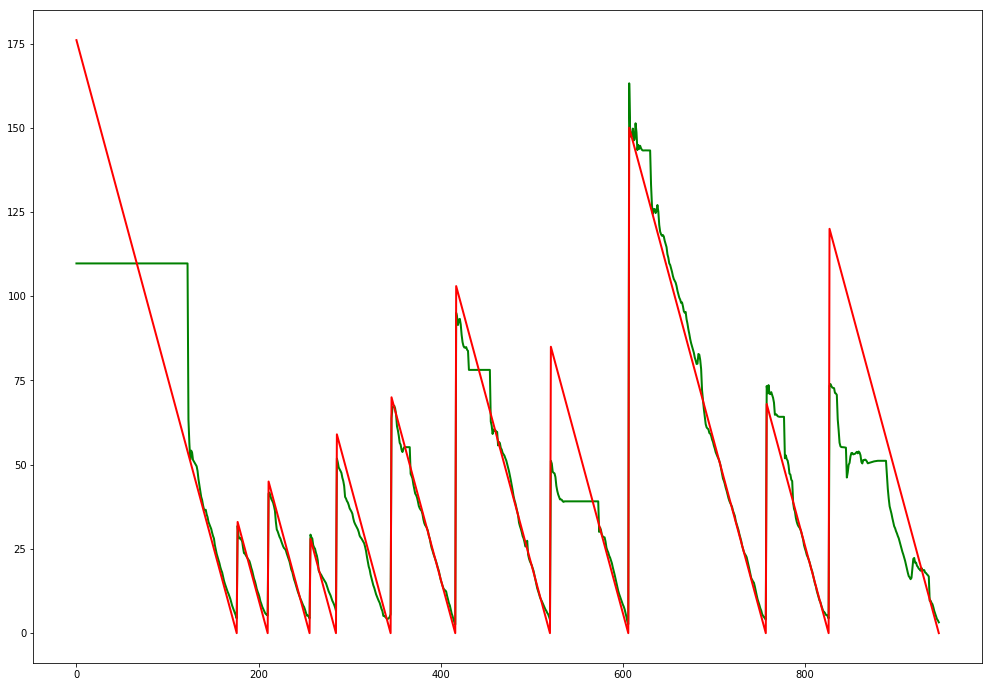

948/948 [==============================] - 0s 196us/step
[10.05030647209425, 10.05030647209425]


In [23]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(seq_y, color='red', linewidth=2, markersize=12)
plt.show()
print(model.evaluate(seq_x, seq_y))

Plot of all test data. True values on the x-axis and predicted values on the y-axis.

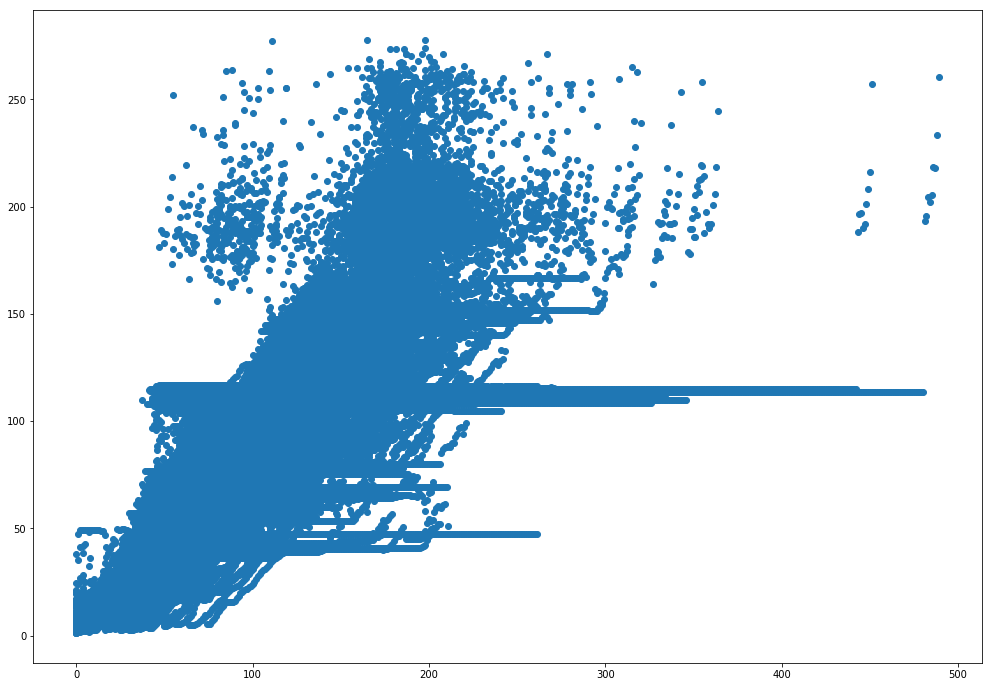

In [25]:
test_predictions = model.predict(seq_test_x)
plt.scatter(seq_test_y, test_predictions)
plt.show()